In [1]:
# If we are on colab: this clones the repo and installs the dependencies
from pathlib import Path

# if Path.cwd().name != "LightGlue":
#     !git clone --quiet https://github.com/cvg/LightGlue/
#     %cd LightGlue
#     !pip install --progress-bar off --quiet -e .

from lightglue import LightGlue, SuperPoint, DISK, SuperPoint_Desc
from lightglue.utils import load_image, rbd
from lightglue import viz2d
import torch

torch.set_grad_enabled(False)
images = Path("data")

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 'mps', 'cpu'

In [3]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

# from siamese.trainer import fit
import numpy as np
cuda = torch.cuda.is_available()

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [4]:
def convert_to_displayable_image(image):
    # Convert from tensor to NumPy if needed
    if torch.is_tensor(image):
        image = image.cpu().detach().numpy()
    
    # If image is float32, scale to [0, 255] and convert to uint8
    if image.dtype == np.float32:
        image = (image * 255).astype(np.uint8)
    
    # If image is in channels-first format, convert to channels-last
    if image.ndim == 3 and image.shape[0] in [1, 3]:
        image = image.transpose(1, 2, 0)  # Convert CxHxW to HxWxC

    return Image.fromarray(image)

#### Method to extract patches from image based on keypoints

In [5]:
def extract_patches(image, keypoints, size=32):
    patches = []
    valid_keypoints = []  # To store keypoints for which patches are created

    # If image is in channels-first format, transpose it to channels-last
    if image.shape[0] < image.shape[1] and image.shape[0] < image.shape[2]:
        image = image.transpose(1, 2, 0)  # Convert to (H, W, C)
    
    for kp in keypoints:
        x, y = int(kp[0]), int(kp[1])
        if x - size // 2 < 0 or y - size // 2 < 0 or x + size // 2 > image.shape[1] or y + size // 2 > image.shape[0]:
            continue  # Skip if the patch would be out of image bounds

        # Extract patch and store the corresponding keypoint
        patch = image[y - size // 2:y + size // 2, x - size // 2:x + size // 2]
        patches.append(patch)
        valid_keypoints.append((kp[0], kp[1]))

    return patches, valid_keypoints

#### Method to show keypoints on the images and draw lines to show matches
The bad matches are shown in red, the good matches are shown in green, lines are also in green or red depending on a good or red match. 

In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
import matplotlib.colors as mcolors
import numpy as np

%matplotlib inline
# Can only be used with a display
# %matplotlib notebook
# matplotlib.use('TkAgg')

patch_size=64

def show_matched_keypoints(image1, image2, good_kpts1, good_kpts2, bad_kpts1, bad_kpts2):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Convert images to displayable format
    image1_np = image1.cpu().numpy().transpose(1, 2, 0)
    image2_np = image2.cpu().numpy().transpose(1, 2, 0)

    print(image1_np.shape)
    print(image2_np.shape)

    # Display original images
    axs[0].imshow(image1_np)
    axs[1].imshow(image2_np)

    # Overlay patches on images
    for i in range(len(good_kpts1)):
        x1, y1 = good_kpts1[i]
        x2, y2 = good_kpts2[i]
        color = 'lime'
        cir1 = patches.Circle((x1, y1), 1, linewidth=1, edgecolor=color, facecolor=color, alpha=1)
        cir2 = patches.Circle((x2, y2), 1, linewidth=1, edgecolor=color, facecolor=color, alpha=1)
        axs[0].add_patch(cir1)
        axs[1].add_patch(cir2)

        # Draw a line connecting the patches
        line = ConnectionPatch(xyA=(x1, y1), xyB=(x2, y2), coordsA='data', coordsB='data', axesA=axs[0], axesB=axs[1], color=color, alpha=0.5, linewidth=1.0)
        axs[1].add_artist(line)

    for i in range(len(bad_kpts1)):
        x1, y1 = bad_kpts1[i]
        x2, y2 = bad_kpts2[i]
        color = 'red'
        cir1 = patches.Circle((x1, y1), 1, linewidth=1, edgecolor=color, facecolor=color, alpha=1)
        cir2 = patches.Circle((x2, y2), 1, linewidth=1, edgecolor=color, facecolor=color, alpha=1)
        axs[0].add_patch(cir1)
        axs[1].add_patch(cir2)

        # Draw a line connecting the patches
        line = ConnectionPatch(xyA=(x1, y1), xyB=(x2, y2), coordsA='data', coordsB='data', axesA=axs[0], axesB=axs[1], color=color, alpha=0.5, linewidth=1.0)
        axs[1].add_artist(line)

    plt.savefig("cos_sp_slice_match.png")
    plt.show()


In [8]:
def filter_keypoints(kpts1, kpts2, img_size=(1024, 1024), patch_size=64):
    valid_kpts1 = []
    valid_kpts2 = []

    half_patch = patch_size // 2

    for kp1, kp2 in zip(kpts1, kpts2):
        if (half_patch <= kp1[0] < img_size[0] - half_patch) and \
           (half_patch <= kp1[1] < img_size[1] - half_patch) and \
           (half_patch <= kp2[0] < img_size[0] - half_patch) and \
           (half_patch <= kp2[1] < img_size[1] - half_patch):
            valid_kpts1.append(kp1)
            valid_kpts2.append(kp2)

    return valid_kpts1, valid_kpts2

In [9]:
from sklearn.metrics.pairwise import cosine_similarity

def find_top_matches(kpts1, kpts2, descriptors1, descriptors2, top_k, similarity_threshold):
    
    # Initialize lists to store matches
    good_match_similarities, bad_match_similarities = [], []
    good_kpts1, good_kpts2  = [], []
    bad_kpts1, bad_kpts2 = [], []

    # Normalize the embeddings
    normalized_descriptors1 = descriptors1 / np.linalg.norm(descriptors1, axis=1, keepdims=True)
    normalized_descriptors2 = descriptors2 / np.linalg.norm(descriptors2, axis=1, keepdims=True)

    similarities = cosine_similarity(normalized_descriptors1, normalized_descriptors2)

    # Compute pairwise distances between embeddings
    # distances = np.linalg.norm(descriptors1[:, np.newaxis] - descriptors2, axis=2)

    # Find the top K matches for each embedding in embeddings1
    # sorted_indices = np.argsort(distances, axis=1)[:, :top_k]
    sorted_indices = np.argsort(similarities, axis=1)[:, ::-1]

    for i, (sorted_idx, emb_similarities) in enumerate(zip(sorted_indices, similarities)):
        # Apply Lowe's ratio test and distance_threshold skipped for SP L2
        if emb_similarities[sorted_idx[0]] >= similarity_threshold:
            ratio = emb_similarities[sorted_idx[1]] / emb_similarities[sorted_idx[0]]
            if ratio < 0.99:
            # if True:
                # Good match
                good_match_similarities.append(emb_similarities[sorted_idx[0]])
                good_kpts1.append(kpts1[i])
                good_kpts2.append(kpts2[sorted_idx[0]])
            else:
                # Bad match
                bad_match_similarities.append(emb_similarities[sorted_idx[0]])
                bad_kpts1.append(kpts1[i])
                bad_kpts2.append(kpts2[sorted_idx[0]])
        else:
            # Insufficient or too high distance
            bad_match_similarities.append(emb_similarities[sorted_idx[0]])
            bad_kpts1.append(kpts1[i])
            bad_kpts2.append(kpts2[sorted_idx[0]])

    return good_match_similarities, bad_match_similarities, good_kpts1, good_kpts2, bad_kpts1, bad_kpts2


In [10]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch
from imageio import imread
import numpy as np

def load_path_for_pytorch(path, max_side=1000, force_scale=False, verbose=True):

    com_f = max

    x = imread(path)
    s = x.shape

    x = x/255.#-0.5
    xt = x.copy()
    
    if len(s) < 3:
        x = np.stack([x,x,x],2)

    if x.shape[2] > 3:
        x = x[:,:,:3]

    x = x.astype(np.float32)
    x = torch.from_numpy(x).contiguous().permute(2,0,1).contiguous()


    if (com_f(s[:2])>max_side and max_side>0) or force_scale:


        fac = float(max_side)/com_f(s[:2])
        x = F.interpolate(x.unsqueeze(0),( int(s[0]*fac), int(s[1]*fac) ), mode='bilinear', align_corners=False)[0]
        so = s
        s = x.shape

    return x

In [11]:
import torch
from PIL import Image
from torchvision.transforms import Resize, ToTensor

def isolate_green_and_mask_image(image_path, mask_path, long_side, device):
    
    # Load the images
    image = load_path_for_pytorch(image_path, long_side, force_scale=True)
    mask = load_path_for_pytorch(mask_path, long_side, force_scale=True)

    # Convert to tensor
    # to_tensor = ToTensor()
    image = image.to(device)
    mask = mask.to(device)

    # Isolate the green channel and create a binary mask
    # Assuming green regions have higher green values compared to red and blue
    green_channel = mask[1, :, :]
    red_channel = mask[0, :, :]
    blue_channel = mask[2, :, :]
    binary_mask = (green_channel > red_channel) & (green_channel > blue_channel)
    binary_mask = binary_mask.float()

    kernel_size = 11  # This corresponds to reducing the ROI by 5 pixels in each direction
    kernel = np.ones((kernel_size, kernel_size), np.uint8)

    # Apply erosion to reduce the ROI
    eroded_mask = cv2.erode(binary_mask.cpu().numpy(), kernel, iterations=1)

    # Apply the mask
    masked_image = image * torch.from_numpy(eroded_mask).unsqueeze(0).to(device)

    return masked_image, binary_mask

In [12]:
def filter_one_to_one_matches(matches):
    # Sort matches based on score so that higher scores come first
    matches.sort(key=lambda x: x[2], reverse=True)
    
    match_index1 = set()
    match_index2 = set()
    filtered_matches = []
    
    for index1, index2, score in matches:
        # If neither index1 nor index2 have been used yet, add the match
        if index1 not in match_index1 and index2 not in match_index2:
            filtered_matches.append((index1, index2, score))
            match_index1.add(index1)
            match_index2.add(index2)
    
    return filtered_matches

/tmp/ipykernel_13677/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


torch.Size([1, 200, 2])
(200, 256)
All Matches: 151
Good Matches: 18
Bad Matches: 133
Percentage of Good Matches: 9.0%
(192, 192, 3)
(192, 192, 3)


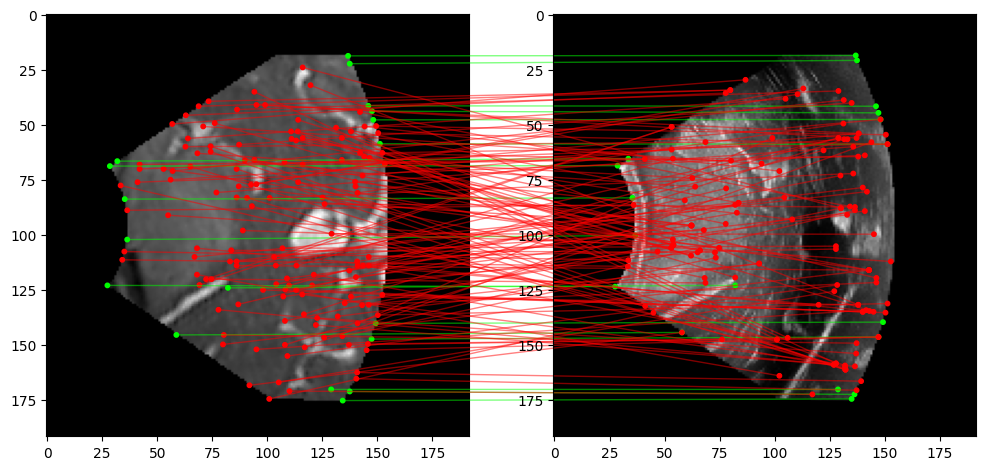

In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
import cv2
from lightglue import SuperPoint


def extract_and_match_patches(image1, feats1, image2, matcher, extractor, device, patch_size=64, top_k=5):
    similarity_threshold = 0.5
    
    # Preprocess and extract patches from both images
    image1 = image1.to(device)
    image2 = image2.to(device)

    #Modified superpoint that uses passed keypoints to sample descriptors
    # extractor = SuperPoint_Desc(max_num_keypoints=256).eval().to(device)
    extractor = SuperPoint(max_num_keypoints=None).eval().to(device)

    # print(feats1["keypoints"])
    print(feats1["keypoints"].shape)
    
    feats2 = extractor.extract(image2)
    
    feats1 = rbd(feats1)
    feats2 = rbd(feats2)

    desc1 = feats1['descriptors'].cpu().numpy()
    desc2 = feats2['descriptors'].cpu().numpy()

    kpts1 = feats1['keypoints'].cpu().numpy()
    kpts2 = feats2['keypoints'].cpu().numpy()

    print(desc1.shape)

    good_match_similarities, bad_match_similarities, good_kpts1, good_kpts2, bad_kpts1, bad_kpts2 = find_top_matches(kpts1, kpts2, desc1, desc2, top_k=top_k, similarity_threshold=similarity_threshold)

    print(f"All Matches: {len(good_kpts1)}")
    
    good_kpts1, good_kpts2, bad_kpts1, bad_kpts2, similar_patches_count = extract_good_and_bad_matches(good_kpts1, good_kpts2)
       
    print(f"Good Matches: {len(good_kpts1)}")
    print(f"Bad Matches: {len(bad_kpts1)}")
    print(f"Percentage of Good Matches: {(len(good_kpts1)/len(kpts1))*100}%")

    show_matched_keypoints(image1, image2, good_kpts1, good_kpts2, bad_kpts1, bad_kpts2)
    
    return kpts1, kpts2, good_kpts1, good_kpts2, bad_kpts1, bad_kpts2


# Extract good and bad matches from the patches based on a margin:
def extract_good_and_bad_matches(good_kpts1, good_kpts2, margin=2):
    count = 0
    
    good_good_kpts1 = []
    good_good_kpts2 = []
    
    bad_good_kpts1 = []
    bad_good_kpts2 = []
    
    
    for i in range(len(good_kpts1)):
        # Get keypoints from both images
        kp1 = good_kpts1[i]
        kp2 = good_kpts2[i]

        # Check if keypoints are within the margin
        if (abs(kp1[0] - kp2[0]) <= margin) and (abs(kp1[1] - kp2[1]) <= margin):
            good_good_kpts1.append(kp1)
            good_good_kpts2.append(kp2)
            count += 1
        else:
            bad_good_kpts1.append(kp1)
            bad_good_kpts2.append(kp2)

    return good_good_kpts1, good_good_kpts2, bad_good_kpts1, bad_good_kpts2, count


def preprocess_image(image):
    # Implement any preprocessing steps (resizing, normalization, etc.)
    transform = transforms.Compose([
        transforms.ToTensor(),  # Converts image to PyTorch tensor in CxHxW format
        transforms.Normalize(mean=(0), std=(1))  # Normalize the image
    ])
    image = transform(image).to(device)
    return image

size = 192

# Example usage
image1 = load_image("data/mr_us/Case096/t2/035.png", resize=size)
image2 = load_image("data/mr_us/Case096/us/035.png", resize=size)

masked_image1, binary_mask = isolate_green_and_mask_image(images/"mr_us/Case096/t2/035.png", images/"mr_us/Case096/us_mask.png", size, device)

extractor = SuperPoint(max_num_keypoints=200).eval().to(device)  # load the extractor
matcher = LightGlue(features="superpoint").eval().to(device)

image1 = image1.to(device)
feats1 = extractor.extract(image1)

kpts1, kpts2, good_kpts1, good_kpts2, bad_kpts1, bad_kpts2 = extract_and_match_patches(image1, feats1, image2, matcher, extractor, device)

In [19]:
def extract_and_match_patches_all(image1, feats1, image2, matcher, extractor, device, patch_size=64, top_k=5):
    similarity_threshold = 0.5
    
    # Preprocess and extract patches from both images
    image1 = image1.to(device)
    image2 = image2.to(device)

    #Modified superpoint that uses passed keypoints to sample descriptors
    # extractor = SuperPoint_Desc(max_num_keypoints=256).eval().to(device)
    extractor = SuperPoint(max_num_keypoints=None).eval().to(device)

    # print(feats1["keypoints"])
    print(feats1["keypoints"].shape)
    
    feats2 = extractor.extract(image2)
    
    feats1 = rbd(feats1)
    feats2 = rbd(feats2)

    desc1 = feats1['descriptors'].cpu().numpy()
    desc2 = feats2['descriptors'].cpu().numpy()

    kpts1 = feats1['keypoints'].cpu().numpy()
    kpts2 = feats2['keypoints'].cpu().numpy()

    print(desc1.shape)

    good_match_similarities, bad_match_similarities, good_kpts1, good_kpts2, bad_kpts1, bad_kpts2 = find_top_matches(kpts1, kpts2, desc1, desc2, top_k=top_k, similarity_threshold=similarity_threshold)

    all_matches = len(good_kpts1)
    print(f"All Matches: {all_matches}")
    
    good_kpts1, good_kpts2, bad_kpts1, bad_kpts2, similar_patches_count = extract_good_and_bad_matches(good_kpts1, good_kpts2)
       
    print(f"Good Matches: {len(good_kpts1)}")
    print(f"Bad Matches: {len(bad_kpts1)}")
    print(f"Percentage of Good Matches: {(len(good_kpts1)/all_matches)*100}%")

    # show_matched_keypoints(image1, image2, good_kpts1, good_kpts2, bad_kpts1, bad_kpts2)
    
    return all_matches, len(good_kpts1), len(bad_kpts1), len(good_kpts1)/all_matches*100, len(bad_kpts1)/all_matches*100

In [20]:
import numpy as np

# Metrics accumulators
total_matches = 0
total_tps = 0
total_fps = 0
total_tpr = 0
total_fpr = 0
slice_count = 78

for i in range(slice_count):
    slice_num = f"{i:03}.png"  # Format the slice number with leading zeros
    t2_path = f"data/mr_us/Case067/t2/{slice_num}"
    us_path = f"data/mr_us/Case067/us/{slice_num}"
    
    # Load images (modify your load_path_for_pytorch function accordingly)
    image1 = load_image(t2_path, resize=size).to(device)
    image2 = load_image(us_path, resize=size).to(device)
    
    # You might need to adjust how keypoints are loaded and processed based on your specific setup
    masked_image1, binary_mask = isolate_green_and_mask_image(images/f"mr_us/Case067/t2/{slice_num}", images/"mr_us/Case096/us_mask.png", size, device)

    # plt.imshow(masked_image1.cpu().numpy().transpose(1,2,0))

    extractor = SuperPoint(max_num_keypoints=200).eval().to(device)
    # image1 = image1.to(device)
    feats1 = extractor.extract(masked_image1)

    print(f"Slice Number: {i}")
    # Perform matching

    all_matches, tps, fps, tpr, fpr = extract_and_match_patches_all(image1, feats1, image2, matcher, extractor, device)
    
    # Accumulate metrics
    total_matches += all_matches
    total_tps += tps
    total_fps += fps
    total_tpr += tpr
    total_fpr += fpr

# Compute averages
avg_matches = total_matches / slice_count
avg_tps = total_tps / slice_count
avg_fps = total_fps / slice_count
avg_tpr = total_tpr / slice_count
avg_fpr = total_fpr / slice_count

print(f"Average Matches: {avg_matches}")
print(f"Average TPs: {avg_tps}")
print(f"Average FPs: {avg_fps}")
print(f"Average TPR: {avg_tpr}%")
print(f"Average FPR: {avg_fpr}%")


/tmp/ipykernel_22337/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22337/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


Slice Number: 0
torch.Size([1, 200, 2])
(200, 256)
All Matches: 161
Good Matches: 0
Bad Matches: 161
Percentage of Good Matches: 0.0%
Slice Number: 1
torch.Size([1, 200, 2])
(200, 256)
All Matches: 150
Good Matches: 7
Bad Matches: 143
Percentage of Good Matches: 4.666666666666667%
Slice Number: 2
torch.Size([1, 200, 2])
(200, 256)
All Matches: 150
Good Matches: 2
Bad Matches: 148
Percentage of Good Matches: 1.3333333333333335%
Slice Number: 3
torch.Size([1, 200, 2])
(200, 256)


/tmp/ipykernel_22337/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22337/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


All Matches: 154
Good Matches: 5
Bad Matches: 149
Percentage of Good Matches: 3.2467532467532463%
Slice Number: 4
torch.Size([1, 200, 2])
(200, 256)
All Matches: 150
Good Matches: 2
Bad Matches: 148
Percentage of Good Matches: 1.3333333333333335%
Slice Number: 5
torch.Size([1, 200, 2])
(200, 256)


/tmp/ipykernel_22337/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22337/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


All Matches: 152
Good Matches: 1
Bad Matches: 151
Percentage of Good Matches: 0.6578947368421052%
Slice Number: 6
torch.Size([1, 200, 2])
(200, 256)
All Matches: 148
Good Matches: 3
Bad Matches: 145
Percentage of Good Matches: 2.027027027027027%
Slice Number: 7
torch.Size([1, 200, 2])
(200, 256)


/tmp/ipykernel_22337/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22337/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22337/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


All Matches: 144
Good Matches: 4
Bad Matches: 140
Percentage of Good Matches: 2.7777777777777777%
Slice Number: 8
torch.Size([1, 200, 2])
(200, 256)
All Matches: 148
Good Matches: 1
Bad Matches: 147
Percentage of Good Matches: 0.6756756756756757%
Slice Number: 9
torch.Size([1, 200, 2])
(200, 256)


/tmp/ipykernel_22337/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22337/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


All Matches: 149
Good Matches: 4
Bad Matches: 145
Percentage of Good Matches: 2.684563758389262%
Slice Number: 10
torch.Size([1, 200, 2])
(200, 256)
All Matches: 152
Good Matches: 1
Bad Matches: 151
Percentage of Good Matches: 0.6578947368421052%
Slice Number: 11
torch.Size([1, 200, 2])
(200, 256)


/tmp/ipykernel_22337/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22337/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22337/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


All Matches: 150
Good Matches: 2
Bad Matches: 148
Percentage of Good Matches: 1.3333333333333335%
Slice Number: 12
torch.Size([1, 200, 2])
(200, 256)
All Matches: 148
Good Matches: 0
Bad Matches: 148
Percentage of Good Matches: 0.0%
Slice Number: 13
torch.Size([1, 200, 2])
(200, 256)
All Matches: 150
Good Matches: 1
Bad Matches: 149
Percentage of Good Matches: 0.6666666666666667%
Slice Number: 14
torch.Size([1, 200, 2])
(200, 256)
All Matches: 157
Good Matches: 1
Bad Matches: 156
Percentage of Good Matches: 0.6369426751592357%
Slice Number: 15
torch.Size([1, 200, 2])
(200, 256)
All Matches: 148
Good Matches: 1
Bad Matches: 147
Percentage of Good Matches: 0.6756756756756757%


/tmp/ipykernel_22337/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22337/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22337/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


Slice Number: 16
torch.Size([1, 200, 2])
(200, 256)
All Matches: 155
Good Matches: 1
Bad Matches: 154
Percentage of Good Matches: 0.6451612903225806%
Slice Number: 17
torch.Size([1, 200, 2])
(200, 256)
All Matches: 146
Good Matches: 4
Bad Matches: 142
Percentage of Good Matches: 2.73972602739726%


/tmp/ipykernel_22337/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22337/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


Slice Number: 18
torch.Size([1, 200, 2])
(200, 256)
All Matches: 154
Good Matches: 4
Bad Matches: 150
Percentage of Good Matches: 2.5974025974025974%
Slice Number: 19
torch.Size([1, 200, 2])
(200, 256)
All Matches: 141
Good Matches: 3
Bad Matches: 138
Percentage of Good Matches: 2.127659574468085%


/tmp/ipykernel_22337/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22337/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22337/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


Slice Number: 20
torch.Size([1, 200, 2])
(200, 256)
All Matches: 142
Good Matches: 3
Bad Matches: 139
Percentage of Good Matches: 2.112676056338028%
Slice Number: 21
torch.Size([1, 200, 2])
(200, 256)
All Matches: 145
Good Matches: 5
Bad Matches: 140
Percentage of Good Matches: 3.4482758620689653%
Slice Number: 22


/tmp/ipykernel_22337/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22337/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


torch.Size([1, 200, 2])
(200, 256)
All Matches: 145
Good Matches: 3
Bad Matches: 142
Percentage of Good Matches: 2.0689655172413794%
Slice Number: 23
torch.Size([1, 200, 2])
(200, 256)
All Matches: 150
Good Matches: 1
Bad Matches: 149
Percentage of Good Matches: 0.6666666666666667%
Slice Number: 24


/tmp/ipykernel_22337/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22337/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22337/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


torch.Size([1, 200, 2])
(200, 256)
All Matches: 143
Good Matches: 0
Bad Matches: 143
Percentage of Good Matches: 0.0%
Slice Number: 25
torch.Size([1, 200, 2])
(200, 256)
All Matches: 151
Good Matches: 0
Bad Matches: 151
Percentage of Good Matches: 0.0%
Slice Number: 26
torch.Size([1, 200, 2])
(200, 256)
All Matches: 157
Good Matches: 4
Bad Matches: 153
Percentage of Good Matches: 2.547770700636943%
Slice Number: 27
torch.Size([1, 200, 2])
(200, 256)
All Matches: 149
Good Matches: 3
Bad Matches: 146
Percentage of Good Matches: 2.013422818791946%
Slice Number: 28


/tmp/ipykernel_22337/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22337/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


torch.Size([1, 200, 2])
(200, 256)
All Matches: 156
Good Matches: 3
Bad Matches: 153
Percentage of Good Matches: 1.9230769230769231%
Slice Number: 29
torch.Size([1, 200, 2])
(200, 256)
All Matches: 149
Good Matches: 0
Bad Matches: 149
Percentage of Good Matches: 0.0%
Slice Number: 30


/tmp/ipykernel_22337/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22337/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22337/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


torch.Size([1, 200, 2])
(200, 256)
All Matches: 143
Good Matches: 1
Bad Matches: 142
Percentage of Good Matches: 0.6993006993006993%
Slice Number: 31
torch.Size([1, 200, 2])
(200, 256)
All Matches: 159
Good Matches: 3
Bad Matches: 156
Percentage of Good Matches: 1.8867924528301887%


/tmp/ipykernel_22337/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22337/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


Slice Number: 32
torch.Size([1, 200, 2])
(200, 256)
All Matches: 161
Good Matches: 0
Bad Matches: 161
Percentage of Good Matches: 0.0%
Slice Number: 33
torch.Size([1, 200, 2])
(200, 256)
All Matches: 141
Good Matches: 1
Bad Matches: 140
Percentage of Good Matches: 0.7092198581560284%


/tmp/ipykernel_22337/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22337/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


Slice Number: 34
torch.Size([1, 200, 2])
(200, 256)
All Matches: 152
Good Matches: 1
Bad Matches: 151
Percentage of Good Matches: 0.6578947368421052%
Slice Number: 35
torch.Size([1, 200, 2])
(200, 256)
All Matches: 139
Good Matches: 0
Bad Matches: 139
Percentage of Good Matches: 0.0%
Slice Number: 36
torch.Size([1, 200, 2])
(200, 256)
All Matches: 145
Good Matches: 3
Bad Matches: 142
Percentage of Good Matches: 2.0689655172413794%


/tmp/ipykernel_22337/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22337/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


Slice Number: 37
torch.Size([1, 200, 2])
(200, 256)
All Matches: 149
Good Matches: 2
Bad Matches: 147
Percentage of Good Matches: 1.342281879194631%
Slice Number: 38
torch.Size([1, 200, 2])
(200, 256)
All Matches: 149
Good Matches: 3
Bad Matches: 146
Percentage of Good Matches: 2.013422818791946%


/tmp/ipykernel_22337/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22337/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


Slice Number: 39
torch.Size([1, 200, 2])
(200, 256)
All Matches: 144
Good Matches: 0
Bad Matches: 144
Percentage of Good Matches: 0.0%
Slice Number: 40
torch.Size([1, 200, 2])
(200, 256)
All Matches: 148
Good Matches: 4
Bad Matches: 144
Percentage of Good Matches: 2.7027027027027026%


/tmp/ipykernel_22337/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22337/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


Slice Number: 41
torch.Size([1, 200, 2])
(200, 256)
All Matches: 137
Good Matches: 3
Bad Matches: 134
Percentage of Good Matches: 2.18978102189781%
Slice Number: 42
torch.Size([1, 200, 2])
(200, 256)
All Matches: 149
Good Matches: 1
Bad Matches: 148
Percentage of Good Matches: 0.6711409395973155%


/tmp/ipykernel_22337/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22337/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


Slice Number: 43
torch.Size([1, 200, 2])
(200, 256)
All Matches: 152
Good Matches: 2
Bad Matches: 150
Percentage of Good Matches: 1.3157894736842104%
Slice Number: 44
torch.Size([1, 200, 2])
(200, 256)
All Matches: 142
Good Matches: 1
Bad Matches: 141
Percentage of Good Matches: 0.7042253521126761%


/tmp/ipykernel_22337/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22337/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


Slice Number: 45
torch.Size([1, 200, 2])
(200, 256)
All Matches: 137
Good Matches: 4
Bad Matches: 133
Percentage of Good Matches: 2.9197080291970803%
Slice Number: 46
torch.Size([1, 200, 2])
(200, 256)
All Matches: 144
Good Matches: 4
Bad Matches: 140
Percentage of Good Matches: 2.7777777777777777%


/tmp/ipykernel_22337/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22337/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


Slice Number: 47
torch.Size([1, 200, 2])
(200, 256)
All Matches: 151
Good Matches: 1
Bad Matches: 150
Percentage of Good Matches: 0.6622516556291391%
Slice Number: 48
torch.Size([1, 200, 2])
(200, 256)
All Matches: 145
Good Matches: 3
Bad Matches: 142
Percentage of Good Matches: 2.0689655172413794%


/tmp/ipykernel_22337/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22337/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22337/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


Slice Number: 49
torch.Size([1, 200, 2])
(200, 256)
All Matches: 154
Good Matches: 2
Bad Matches: 152
Percentage of Good Matches: 1.2987012987012987%
Slice Number: 50
torch.Size([1, 200, 2])
(200, 256)
All Matches: 144
Good Matches: 2
Bad Matches: 142
Percentage of Good Matches: 1.3888888888888888%


/tmp/ipykernel_22337/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22337/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


Slice Number: 51
torch.Size([1, 200, 2])
(200, 256)
All Matches: 154
Good Matches: 4
Bad Matches: 150
Percentage of Good Matches: 2.5974025974025974%
Slice Number: 52
torch.Size([1, 200, 2])
(200, 256)
All Matches: 136
Good Matches: 0
Bad Matches: 136
Percentage of Good Matches: 0.0%


/tmp/ipykernel_22337/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22337/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22337/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


Slice Number: 53
torch.Size([1, 200, 2])
(200, 256)
All Matches: 151
Good Matches: 0
Bad Matches: 151
Percentage of Good Matches: 0.0%
Slice Number: 54
torch.Size([1, 200, 2])
(200, 256)
All Matches: 145
Good Matches: 1
Bad Matches: 144
Percentage of Good Matches: 0.6896551724137931%
Slice Number: 55
torch.Size([1, 200, 2])
(200, 256)
All Matches: 145
Good Matches: 2
Bad Matches: 143
Percentage of Good Matches: 1.3793103448275863%
Slice Number: 56
torch.Size([1, 200, 2])
(200, 256)
All Matches: 141
Good Matches: 1
Bad Matches: 140
Percentage of Good Matches: 0.7092198581560284%


/tmp/ipykernel_22337/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22337/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


Slice Number: 57
torch.Size([1, 200, 2])
(200, 256)
All Matches: 158
Good Matches: 2
Bad Matches: 156
Percentage of Good Matches: 1.2658227848101267%
Slice Number: 58
torch.Size([1, 200, 2])
(200, 256)
All Matches: 149
Good Matches: 1
Bad Matches: 148
Percentage of Good Matches: 0.6711409395973155%


/tmp/ipykernel_22337/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22337/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


Slice Number: 59
torch.Size([1, 200, 2])
(200, 256)
All Matches: 135
Good Matches: 0
Bad Matches: 135
Percentage of Good Matches: 0.0%
Slice Number: 60
torch.Size([1, 200, 2])
(200, 256)
All Matches: 141
Good Matches: 1
Bad Matches: 140
Percentage of Good Matches: 0.7092198581560284%


/tmp/ipykernel_22337/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22337/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22337/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


Slice Number: 61
torch.Size([1, 200, 2])
(200, 256)
All Matches: 139
Good Matches: 1
Bad Matches: 138
Percentage of Good Matches: 0.7194244604316548%
Slice Number: 62
torch.Size([1, 200, 2])
(200, 256)
All Matches: 140
Good Matches: 1
Bad Matches: 139
Percentage of Good Matches: 0.7142857142857143%


/tmp/ipykernel_22337/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22337/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22337/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


Slice Number: 63
torch.Size([1, 200, 2])
(200, 256)
All Matches: 146
Good Matches: 1
Bad Matches: 145
Percentage of Good Matches: 0.684931506849315%
Slice Number: 64
torch.Size([1, 200, 2])
(200, 256)
All Matches: 145
Good Matches: 4
Bad Matches: 141
Percentage of Good Matches: 2.7586206896551726%
Slice Number: 65
torch.Size([1, 200, 2])
(200, 256)
All Matches: 151
Good Matches: 2
Bad Matches: 149
Percentage of Good Matches: 1.3245033112582782%
Slice Number: 66
torch.Size([1, 200, 2])
(200, 256)
All Matches: 147
Good Matches: 6
Bad Matches: 141
Percentage of Good Matches: 4.081632653061225%


/tmp/ipykernel_22337/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22337/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


Slice Number: 67
torch.Size([1, 200, 2])
(200, 256)
All Matches: 156
Good Matches: 2
Bad Matches: 154
Percentage of Good Matches: 1.282051282051282%
Slice Number: 68
torch.Size([1, 200, 2])
(200, 256)
All Matches: 128
Good Matches: 3
Bad Matches: 125
Percentage of Good Matches: 2.34375%


/tmp/ipykernel_22337/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22337/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


Slice Number: 69
torch.Size([1, 200, 2])
(200, 256)
All Matches: 145
Good Matches: 1
Bad Matches: 144
Percentage of Good Matches: 0.6896551724137931%
Slice Number: 70
torch.Size([1, 200, 2])
(200, 256)
All Matches: 156
Good Matches: 3
Bad Matches: 153
Percentage of Good Matches: 1.9230769230769231%


/tmp/ipykernel_22337/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22337/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


Slice Number: 71
torch.Size([1, 200, 2])
(200, 256)
All Matches: 148
Good Matches: 1
Bad Matches: 147
Percentage of Good Matches: 0.6756756756756757%


/tmp/ipykernel_22337/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


Slice Number: 72
torch.Size([1, 200, 2])
(200, 256)
All Matches: 149
Good Matches: 1
Bad Matches: 148
Percentage of Good Matches: 0.6711409395973155%
Slice Number: 73


/tmp/ipykernel_22337/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22337/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


torch.Size([1, 200, 2])
(200, 256)
All Matches: 141
Good Matches: 2
Bad Matches: 139
Percentage of Good Matches: 1.4184397163120568%
Slice Number: 74
torch.Size([1, 200, 2])
(200, 256)
All Matches: 153
Good Matches: 5
Bad Matches: 148
Percentage of Good Matches: 3.2679738562091507%
Slice Number: 75
torch.Size([1, 200, 2])
(200, 256)
All Matches: 148
Good Matches: 3
Bad Matches: 145
Percentage of Good Matches: 2.027027027027027%


/tmp/ipykernel_22337/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)
/tmp/ipykernel_22337/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


Slice Number: 76
torch.Size([1, 200, 2])
(200, 256)
All Matches: 147
Good Matches: 4
Bad Matches: 143
Percentage of Good Matches: 2.7210884353741496%
Slice Number: 77
torch.Size([1, 200, 2])
(200, 256)
All Matches: 139
Good Matches: 1
Bad Matches: 138
Percentage of Good Matches: 0.7194244604316548%
Average Matches: 147.5897435897436
Average TPs: 2.08974358974359
Average FPs: 145.5
Average TPR: 1.4152131625224096%
Average FPR: 98.5847868374776%


/tmp/ipykernel_22337/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


In [13]:
# import torch
# import numpy as np
# import matplotlib.pyplot as plt
# from torchvision.transforms.functional import to_pil_image

# def plot_matched_patches(patches1, patches2):
#     # Iterate over each patch in patches1
#     count = 0
#     for i in range(len(patches1)):
#         # Get the top match for patch1
#         patch1 = patches1[i]
#         patch2 = patches2[i]

#         # Create a subplot for each pair of patches
#         fig, axs = plt.subplots(1, 2, figsize=(6, 3))
#         axs[0].imshow(patch1)
#         axs[0].set_title(f"Original Patch\nIndex: {count}")
#         axs[0].axis('off')
        
#         axs[1].imshow(patch2)
#         axs[1].set_title(f"Matched Patch")
#         axs[1].axis('off')

#         plt.show()
#         count+=1



# plot_matched_patches(good_patches1, good_patches2)
# plot_matched_patches(bad_good_patches1, bad_good_patches2, bad_good_distances)

In [11]:
import os

def match_with_all_styles(anchor_image, styles_folder, matcher, extractor, device):
    style_keypoints = {}  # Dictionary to store good keypoints for each style
    matched_anchor_keypoints = {}  # Dictionary to store anchor keypoints for each style
    max_matched_style = None
    max_matched_count = 0

    anchor_image = anchor_image.to(device)
    anchor_feats = extractor.extract(image1)
    anchor_feats_wob = rbd(anchor_feats)
    anchor_keypoints = anchor_feats_wob['keypoints']
    

    for style_image_name in os.listdir(styles_folder):
        style_image_path = os.path.join(styles_folder, style_image_name)
        style_image = load_image(style_image_path)
        
        _, _, good_kpts1, good_kpts2, _, _ = extract_and_match_patches(
            anchor_image, anchor_feats, style_image, matcher, extractor, device
        )

        matched_anchor_keypoints[style_image_name] = good_kpts1
        style_keypoints[style_image_name] = good_kpts2

        # Check if current style has the highest number of matched keypoints
        if len(good_kpts1) > max_matched_count:
            max_matched_count = len(good_kpts1)
            max_matched_style = style_image_name

    print(f"Style with most matches: {max_matched_style}, Matches: {max_matched_count}")

    return anchor_keypoints, matched_anchor_keypoints, style_keypoints, max_matched_style

# Example usage
anchor_image = load_image('data/0_output_mr.png')
styles_folder = 'data/vrmr_guided/0_output_mr'
anchor_keypoints, matched_anchor_keypoints, style_keypoints, max_matched_style = match_with_all_styles(anchor_image, styles_folder, matcher, extractor, device)

tensor([[[357.,  34.],
         [939.,  57.],
         [ 66.,  69.],
         ...,
         [524., 102.],
         [404., 740.],
         [ 45., 853.]]], device='cuda:0')
torch.Size([1, 2048, 2])
(2048, 256)
All Matches: 2014
Good Matches: 1003
Bad Matches: 1011
Percentage of Good Matches: 48.974609375%
tensor([[[357.,  34.],
         [939.,  57.],
         [ 66.,  69.],
         ...,
         [524., 102.],
         [404., 740.],
         [ 45., 853.]]], device='cuda:0')
torch.Size([1, 2048, 2])
(2048, 256)
All Matches: 2002
Good Matches: 1097
Bad Matches: 905
Percentage of Good Matches: 53.564453125%
tensor([[[357.,  34.],
         [939.,  57.],
         [ 66.,  69.],
         ...,
         [524., 102.],
         [404., 740.],
         [ 45., 853.]]], device='cuda:0')
torch.Size([1, 2048, 2])
(2048, 256)
All Matches: 2037
Good Matches: 1720
Bad Matches: 317
Percentage of Good Matches: 83.984375%
tensor([[[357.,  34.],
         [939.,  57.],
         [ 66.,  69.],
         ...,
       

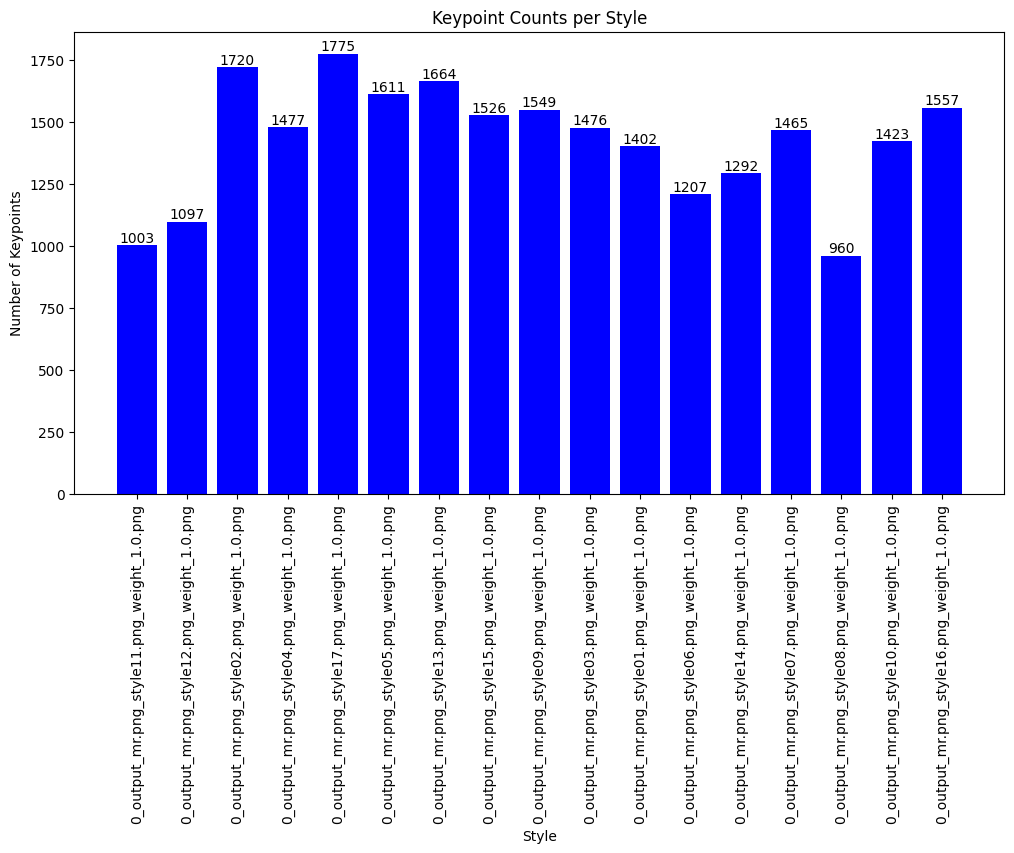

In [12]:
import matplotlib.pyplot as plt

def plot_keypoints_bar_chart(keypoints_dict):
    # Extracting style names and counts of keypoints
    styles = list(keypoints_dict.keys())
    counts = [len(keypoints_dict[style]) for style in styles]

    # Plotting
    plt.figure(figsize=(12, 6))
    bars = plt.bar(styles, counts, color='blue')

    # Adding count labels on top of each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

    plt.xlabel('Style')
    plt.ylabel('Number of Keypoints')
    plt.title('Keypoint Counts per Style')
    plt.xticks(rotation=90)
    plt.show()

plot_keypoints_bar_chart(style_keypoints)


In [13]:
import numpy as np

def is_keypoint_in_list(style_keypoints, r_kp, margin):
    style_kps_array = np.array(style_keypoints)

    # Compute the absolute difference
    diff = np.abs(style_kps_array - r_kp.cpu().numpy())

    # Check if any keypoint is within the margin
    return np.any(np.all(diff <= margin, axis=1))

def find_consistent_keypoints(reference_keypoints, all_style_keypoints, margin=0):
    consistent_keypoints = []

    for r_kp in reference_keypoints:
        if all(is_keypoint_in_list(style_kps, r_kp, margin) for style_kps in all_style_keypoints.values()):
            consistent_keypoints.append(r_kp)
    
    return consistent_keypoints

# Use the keypoints from the most matched style to check consistency over all styles
consistent_keypoints = find_consistent_keypoints(anchor_keypoints, style_keypoints, margin=0)

print("Number of consistent keypoints across all styles:", len(consistent_keypoints))

Number of consistent keypoints across all styles: 134


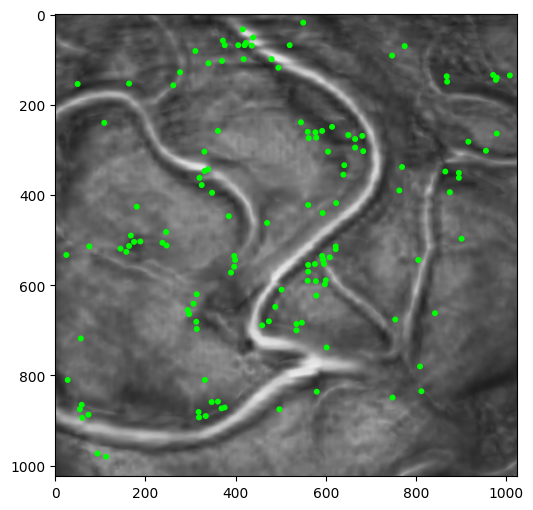

In [14]:
def match_consistent_keypoints(image1, consistent_keypoints, patch_size=64):
    # Preprocess and extract patches from both images
    image1 = image1.to(device)

    fig, axs = plt.subplots(1, 1, figsize=(6, 6))

    # Convert images to displayable format
    image1_np = image1.cpu().numpy().transpose(1, 2, 0)

    # Display original images
    
    axs.imshow(image1_np)

    # Overlay patches on images
    for i in range(len(consistent_keypoints)):
        x1, y1 = consistent_keypoints[i]
        color = 'lime'
        cir1 = patches.Circle((x1, y1), 5, linewidth=1, edgecolor=color, facecolor=color, alpha=1)
        axs.add_patch(cir1)

    plt.show()

match_consistent_keypoints(image1, consistent_keypoints)

In [15]:
def get_sim_of_consistent_points(anchor_image, styles_folder, consistent_points, device):

    style_similarities = {}
    stacked_consistent_points = convert_to_tensor_of_tensors(consistent_points)
    extractor = SuperPoint_Desc(max_num_keypoints=2048).eval().to(device)

    anchor_image = anchor_image.to(device)
    feats1 = extractor.extract(anchor_image, stacked_consistent_points)
    feats1 = rbd(feats1)
    descriptors1 = feats1['descriptors'].cpu().numpy()
    normalized_descriptors1 = descriptors1/np.linalg.norm(descriptors1, axis=1, keepdims=True)
    
    for style_image_name in os.listdir(styles_folder):
        style_image_path = os.path.join(styles_folder, style_image_name)
        style_image = load_image(style_image_path)

        style_image = style_image.to(device)
        feats2 = extractor.extract(style_image, stacked_consistent_points)
        feats2 = rbd(feats2)
        descriptors2 = feats2['descriptors'].cpu().numpy()
        normalized_descriptors2 = descriptors2/np.linalg.norm(descriptors2, axis=1, keepdims=True)
        
        similarities = np.diag(cosine_similarity(normalized_descriptors1, normalized_descriptors2))
        style_similarities[style_image_name] = similarities

    return style_similarities

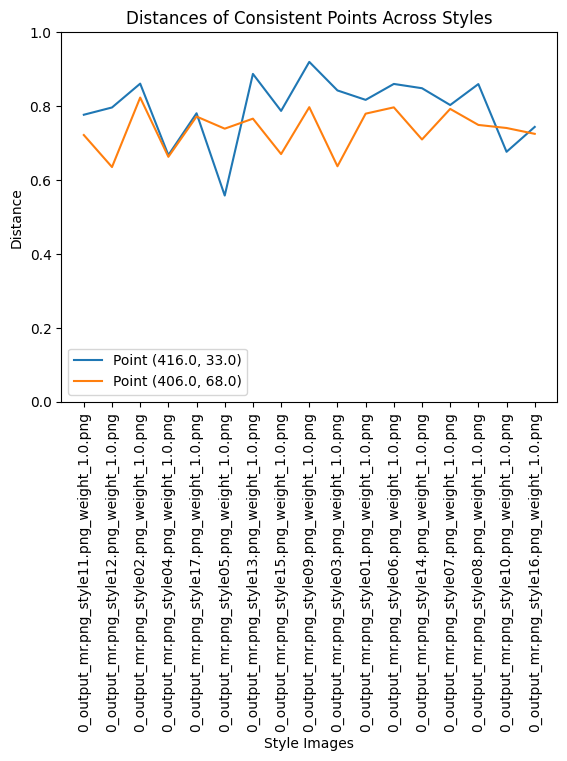

In [17]:
def convert_to_tensor_of_tensors(consistent_points):
    # Stack the list of tensors to create a tensor of shape (num_of_keypoints, 2)
    stacked_points = torch.stack(consistent_points, dim=0)

    # Unsqueeze to add an additional dimension at the beginning
    # Resulting shape: (1, num_of_keypoints, 2)
    tensor_of_tensors = stacked_points.unsqueeze(0)

    return tensor_of_tensors

def plot_style_similarities(style_distances, consistent_points):
    # Prepare data for plotting
    styles = list(style_distances.keys())
    distances = [style_distances[style] for style in styles]
    
    # Plotting each point's distance across styles
    for i in range(len(distances[:2])):
        point_x, point_y = consistent_points[i]
        plt.plot(styles, [dist[i] for dist in distances], label=f'Point ({point_x}, {point_y})')

    plt.xlabel('Style Images')
    plt.ylabel('Distance')
    plt.title('Distances of Consistent Points Across Styles')
    plt.legend()
    plt.xticks(rotation=90)

    plt.ylim(0,1)
    
    plt.savefig("dist_cos_superpoint.png")
    plt.show()

anchor_image = load_image('data/0_output_mr.png')
styles_folder = 'data/vrmr_guided/0_output_mr'
style_similarities = get_sim_of_consistent_points(anchor_image, styles_folder, consistent_keypoints, device)

plot_style_similarities(style_similarities, consistent_keypoints)

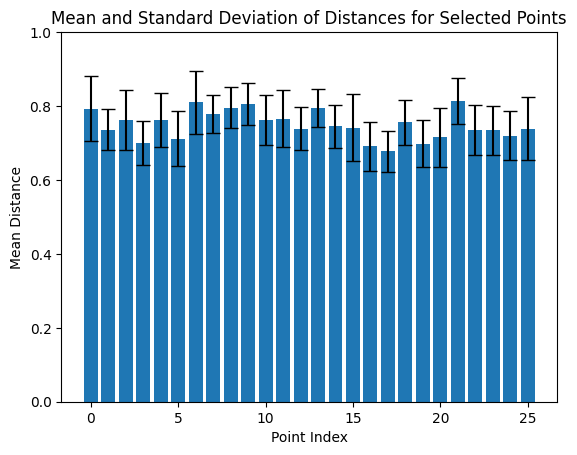

In [19]:
import numpy as np

mean_similarities = {}
std_similarities = {}

for point_index in range(len(consistent_keypoints)):
    point_similarities = np.array([style_similarities[style][point_index] for style in style_similarities.keys()])
    mean_similarities[point_index] = np.mean(point_similarities)
    std_similarities[point_index] = np.std(point_similarities)

selected_points = [0, 1, 2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25]  # Replace with indices of points you want to plot
selected_means = [mean_similarities[i] for i in selected_points]
selected_stds = [std_similarities[i] for i in selected_points]

plt.bar(range(len(selected_points)), selected_means, yerr=selected_stds, capsize=5)
plt.xlabel('Point Index')
plt.ylabel('Mean Distance')
plt.title('Mean and Standard Deviation of Distances for Selected Points')
# plt.xticks(range(len(selected_points)), [f'Point {i}' for i in selected_points])

plt.ylim(0,1)

plt.savefig("stdmean_cos_superpoint.png")

plt.show()

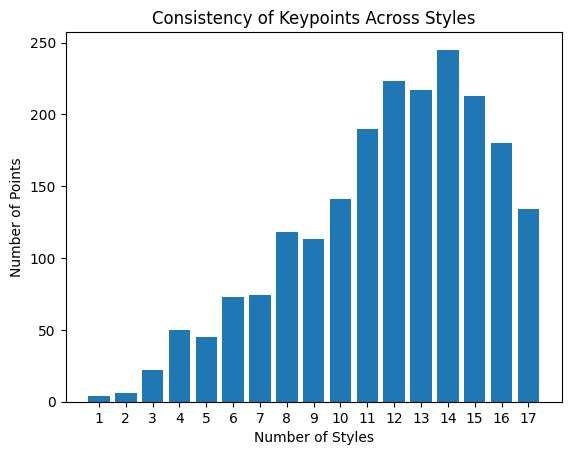

In [20]:
import matplotlib.pyplot as plt

def find_consistency_counts(reference_keypoints, all_style_keypoints, margin=0):
    consistency_counts = {}

    for r_kp in reference_keypoints:
        count = sum(is_keypoint_in_list(style_kps, r_kp, margin) for style_kps in all_style_keypoints.values())
        if count > 0:
            consistency_counts.setdefault(count, 0)
            consistency_counts[count] += 1

    return consistency_counts

# Calculate consistency counts
consistency_counts = find_consistency_counts(anchor_keypoints, style_keypoints, margin=0)

# Plotting the consistency counts
style_counts = list(consistency_counts.keys())
num_points = list(consistency_counts.values())

plt.bar(style_counts, num_points)
plt.xlabel('Number of Styles')
plt.ylabel('Number of Points')
plt.title('Consistency of Keypoints Across Styles')
plt.xticks(style_counts)  # Ensure that all style counts are shown as x-ticks
plt.savefig('cos_sp_consistency_kp_count.png')
plt.show()

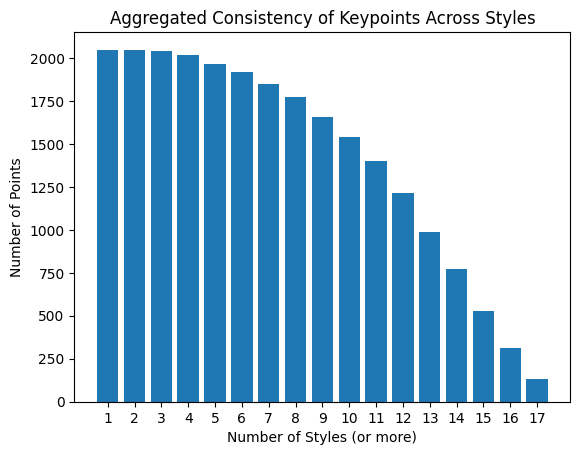

In [24]:
def aggregate_counts(consistency_counts):
    aggregated_counts = {}
    max_count = max(consistency_counts.keys())
    min_count = min(consistency_counts.keys())

    cumulative_count = 0
    for count in range(max_count, min_count - 1, -1):
        cumulative_count += consistency_counts.get(count, 0)
        aggregated_counts[count] = cumulative_count

    return aggregated_counts

# Aggregate consistency counts
aggregated_counts = aggregate_counts(consistency_counts)

# Prepare the data for plotting
min_count = min(aggregated_counts.keys())
max_count = max(aggregated_counts.keys())
style_counts = list(range(min_count, max_count + 1))
num_points = [aggregated_counts.get(count, aggregated_counts[min_count]) for count in style_counts]

plt.bar(style_counts, num_points)
plt.xlabel('Number of Styles (or more)')
plt.ylabel('Number of Points')
plt.title('Aggregated Consistency of Keypoints Across Styles')
plt.xticks(style_counts)  # Ensure that all style counts are shown as x-ticks
plt.savefig('cos_sp_aggr_consistency_kp_count.png')
plt.show()

In [22]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import requests
from torch.nn.functional import cosine_similarity

# Load a pre-trained VGG model
vgg = models.vgg16(pretrained=True).features

# Function to preprocess the image
def preprocess_image(img_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    image = Image.open(img_path).convert('RGB')
    return transform(image).unsqueeze(0)

# Function to calculate the Gram matrix
def gram_matrix(y):
    (b, ch, h, w) = y.size()
    features = y.view(b, ch, w * h)
    features_t = features.transpose(1, 2)
    gram = features.bmm(features_t) / (ch * h * w)
    return gram

# Function to extract feature maps and compute Gram matrix
def get_gram_matrix(image_path):
    image = preprocess_image(image_path)
    features = vgg(image)
    return gram_matrix(features)

# URLs of two images
image1_path = "data/0_output_mr.png"
image2_path = "data/vrmr_guided/0_output_mr/0_output_mr.png_style01.png_weight_1.0.png"

# Calculate Gram matrices
gram_matrix1 = get_gram_matrix(image1_path)
gram_matrix2 = get_gram_matrix(image2_path)

# Compare the Gram matrices using cosine similarity
similarity = cosine_similarity(gram_matrix1.view(1, -1), gram_matrix2.view(1, -1))

similarity.item()

/home/exouser/anaconda3/envs/matching/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/exouser/anaconda3/envs/matching/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


0.2546524107456207

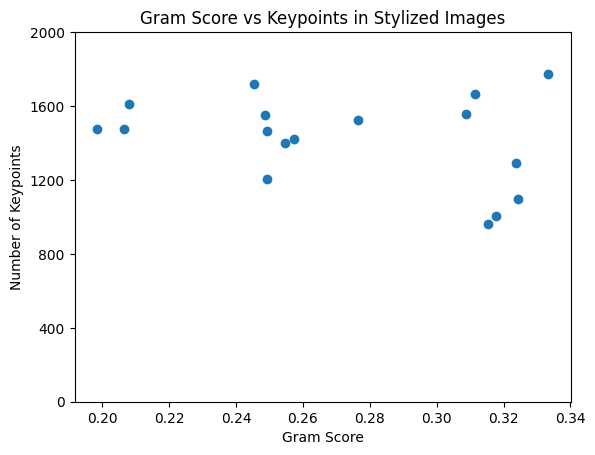

In [23]:
import os
import cv2
import matplotlib.pyplot as plt

def get_keypoints(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    orb = cv2.ORB_create()
    keypoints, _ = orb.detectAndCompute(gray, None)
    return len(keypoints)

# Directory containing stylized images
image_directory = "data/vrmr_guided/0_output_mr"

# Initialize lists to store results
gram_scores = []
keypoint_counts = []

# Iterate over each image in the directory
for image_name in os.listdir(image_directory):
    image_path = os.path.join(image_directory, image_name)

    # Skip if it's not an image
    if not image_path.lower().endswith(('.png', '.jpg', '.jpeg')):
        continue

    # Calculate Gram matrix and similarity score
    gram_matrix_stylized = get_gram_matrix(image_path)
    similarity = cosine_similarity(gram_matrix1.view(1, -1), gram_matrix_stylized.view(1, -1))
    gram_scores.append(similarity.item())

    # Get the number of keypoints
    # keypoint_count = get_keypoints(image_path)
    keypoint_count = len(style_keypoints[image_name])
    keypoint_counts.append(keypoint_count)

# Plotting
plt.scatter(gram_scores, keypoint_counts)
plt.xlabel('Gram Score')
plt.ylabel('Number of Keypoints')
plt.yticks([0,400,800,1200,1600,2000])
plt.title('Gram Score vs Keypoints in Stylized Images')
plt.savefig('cos_superpoint_gram_score_keypoints.png')
plt.show()